<a href="https://colab.research.google.com/github/ThierrryScotto/Ocorrencias-Criminais---Sinesp/blob/master/Robbery_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [68]:
!pip install skforecast --quiet
!pip install fbprophet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [69]:
from xgboost import XGBRegressor
from prophet import Prophet

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

# Getting the data

In [4]:
# dataset = pd.read_excel('indicadoressegurancapublicauf.xlsx')
dataset = pd.read_excel('/content/indicadoressegurancapublicauf.xlsx')
dataset.head(5)

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2022,janeiro,31
1,Acre,Furto de veículo,2022,janeiro,50
2,Acre,Homicídio doloso,2022,janeiro,10
3,Acre,Lesão corporal seguida de morte,2022,janeiro,1
4,Acre,Roubo a instituição financeira,2022,janeiro,0


In [5]:
dataset.rename(columns={
  'UF': 'State',
  'Tipo Crime': 'Crimes',
  'Ano': 'Year',
  'Mês': 'Month',
  'Ocorrências': 'Occurrences'
  }, inplace=True)

dataset.columns

Index(['State', 'Crimes', 'Year', 'Month', 'Occurrences'], dtype='object')

# Data Preparation

In [6]:
STATE = 'São Paulo'

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23020 entries, 0 to 23019
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State        23020 non-null  object
 1   Crimes       23020 non-null  object
 2   Year         23020 non-null  int64 
 3   Month        23020 non-null  object
 4   Occurrences  23020 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 899.3+ KB


In [8]:
dataset.shape

(23020, 5)

In [9]:
dataset.columns

Index(['State', 'Crimes', 'Year', 'Month', 'Occurrences'], dtype='object')

In [10]:
dataset.isnull().sum()

State          0
Crimes         0
Year           0
Month          0
Occurrences    0
dtype: int64

In [11]:
dataset_bank_robbery   = dataset[dataset['Crimes'] == 'Roubo a instituição financeira']
dataset_cargo_theft    = dataset[dataset['Crimes'] == 'Roubo de carga']
dataset_vehicle_theft  = dataset[dataset['Crimes'] == 'Roubo de veículo']
dataset_robbery_murder = dataset[dataset['Crimes'] == 'Roubo seguido de morte (latrocínio)']

In [12]:
concat_dataset = pd.concat([dataset_bank_robbery,
                          dataset_cargo_theft,
                          dataset_vehicle_theft,
                          dataset_robbery_murder], ignore_index=True)

concat_dataset

,State,Crimes,Year,Month,Occurrences
0,Acre,Roubo a instituição financeira,2022,janeiro,0
1,Acre,Roubo a instituição financeira,2022,fevereiro,0
2,Acre,Roubo a instituição financeira,2022,março,0
3,Alagoas,Roubo a instituição financeira,2022,janeiro,0
4,Alagoas,Roubo a instituição financeira,2022,fevereiro,0
...,...,...,...,...,...
10124,Tocantins,Roubo seguido de morte (latrocínio),2015,agosto,1
10125,Tocantins,Roubo seguido de morte (latrocínio),2015,setembro,0
10126,Tocantins,Roubo seguido de morte (latrocínio),2015,outubro,1
10127,Tocantins,Roubo seguido de morte (latrocínio),2015,novembro,0


In [13]:
concat_dataset['Crimes'].unique()

array(['Roubo a instituição financeira', 'Roubo de carga',
       'Roubo de veículo', 'Roubo seguido de morte (latrocínio)'],
      dtype=object)

In [14]:
concat_dataset[concat_dataset['State'] == STATE]

,State,Crimes,Year,Month,Occurrences
250,São Paulo,Roubo a instituição financeira,2022,janeiro,1
251,São Paulo,Roubo a instituição financeira,2022,fevereiro,1
252,São Paulo,Roubo a instituição financeira,2022,março,1
253,São Paulo,Roubo a instituição financeira,2022,abril,2
254,São Paulo,Roubo a instituição financeira,2022,maio,1
...,...,...,...,...,...
10100,São Paulo,Roubo seguido de morte (latrocínio),2015,agosto,29
10101,São Paulo,Roubo seguido de morte (latrocínio),2015,setembro,21
10102,São Paulo,Roubo seguido de morte (latrocínio),2015,outubro,39
10103,São Paulo,Roubo seguido de morte (latrocínio),2015,novembro,26


In [15]:
state_dataset = concat_dataset[concat_dataset['State'] == STATE]
state_dataset.head(5)

,State,Crimes,Year,Month,Occurrences
250,São Paulo,Roubo a instituição financeira,2022,janeiro,1
251,São Paulo,Roubo a instituição financeira,2022,fevereiro,1
252,São Paulo,Roubo a instituição financeira,2022,março,1
253,São Paulo,Roubo a instituição financeira,2022,abril,2
254,São Paulo,Roubo a instituição financeira,2022,maio,1


In [16]:
state_dataset.loc[:,'State'] = 'SP'
state_dataset

<ipython-input-16-44f5c8d7486f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_dataset.loc[:,'State'] = 'SP'


,State,Crimes,Year,Month,Occurrences
250,SP,Roubo a instituição financeira,2022,janeiro,1
251,SP,Roubo a instituição financeira,2022,fevereiro,1
252,SP,Roubo a instituição financeira,2022,março,1
253,SP,Roubo a instituição financeira,2022,abril,2
254,SP,Roubo a instituição financeira,2022,maio,1
...,...,...,...,...,...
10100,SP,Roubo seguido de morte (latrocínio),2015,agosto,29
10101,SP,Roubo seguido de morte (latrocínio),2015,setembro,21
10102,SP,Roubo seguido de morte (latrocínio),2015,outubro,39
10103,SP,Roubo seguido de morte (latrocínio),2015,novembro,26


### Converting month from str to int

In [17]:
state_dataset['Month'].unique()

array(['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho',
       'agosto', 'setembro', 'outubro', 'novembro', 'dezembro'],
      dtype=object)

In [18]:
month_dic = {
 'janeiro': 1,
 'fevereiro': 2,
 'março': 3,
 'abril': 4,
 'maio': 5,
 'junho': 6,
 'julho': 7,
 'agosto': 8,
 'setembro': 9,
 'outubro': 10,
 'novembro': 11,
 'dezembro': 12
}

In [19]:
state_dataset['Month'] = state_dataset['Month'].map(month_dic)
state_dataset['Month']

<ipython-input-19-2e246715cfb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_dataset['Month'] = state_dataset['Month'].map(month_dic)


250       1
251       2
252       3
253       4
254       5
         ..
10100     8
10101     9
10102    10
10103    11
10104    12
Name: Month, Length: 384, dtype: int64

In [20]:
sorted_dataset = state_dataset.sort_values(by=['Year', 'Month'])
sorted_dataset.tail(12)

,State,Crimes,Year,Month,Occurrences
259,SP,Roubo a instituição financeira,2022,10,1
2770,SP,Roubo de carga,2022,10,508
5264,SP,Roubo de veículo,2022,10,3945
7839,SP,Roubo seguido de morte (latrocínio),2022,10,11
260,SP,Roubo a instituição financeira,2022,11,0
2771,SP,Roubo de carga,2022,11,550
5265,SP,Roubo de veículo,2022,11,4107
7840,SP,Roubo seguido de morte (latrocínio),2022,11,17
261,SP,Roubo a instituição financeira,2022,12,2
2772,SP,Roubo de carga,2022,12,588


In [21]:
sorted_dataset = sorted_dataset.copy()
sorted_dataset['Crimes'] = 'robbery'
sorted_dataset['Crimes'].head(5)

2465     robbery
4932     robbery
7522     robbery
10093    robbery
2466     robbery
Name: Crimes, dtype: object

In [22]:
sorted_dataset

,State,Crimes,Year,Month,Occurrences
2465,SP,robbery,2015,1,17
4932,SP,robbery,2015,1,782
7522,SP,robbery,2015,1,7490
10093,SP,robbery,2015,1,33
2466,SP,robbery,2015,2,17
...,...,...,...,...,...
7840,SP,robbery,2022,11,17
261,SP,robbery,2022,12,2
2772,SP,robbery,2022,12,588
5266,SP,robbery,2022,12,4423


In [23]:
sorted_dataset.drop(columns=['State', 'Crimes'], inplace=True)

In [24]:
sorted_dataset

,Year,Month,Occurrences
2465,2015,1,17
4932,2015,1,782
7522,2015,1,7490
10093,2015,1,33
2466,2015,2,17
...,...,...,...
7840,2022,11,17
261,2022,12,2
2772,2022,12,588
5266,2022,12,4423


In [25]:
grouped_df = sorted_dataset.groupby(by=['Year', 'Month'], as_index=False).sum()
grouped_df

,Year,Month,Occurrences
0,2015,1,8322
1,2015,2,7248
2,2015,3,7792
3,2015,4,7392
4,2015,5,6949
...,...,...,...
91,2022,8,3556
92,2022,9,3773
93,2022,10,4465
94,2022,11,4674


## Creating date column

In [26]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         96 non-null     int64
 1   Month        96 non-null     int64
 2   Occurrences  96 non-null     int64
dtypes: int64(3)
memory usage: 2.4 KB


In [27]:
dates = []
for index in range(len(grouped_df)):
    dates.append(f"{grouped_df['Year'][index]}-{grouped_df['Month'][index]}")

print(dates)

['2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6', '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8', '2017-9', '2017-10', '2017-11', '2017-12', '2018-1', '2018-2', '2018-3', '2018-4', '2018-5', '2018-6', '2018-7', '2018-8', '2018-9', '2018-10', '2018-11', '2018-12', '2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10', '2019-11', '2019-12', '2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']


In [28]:
grouped_df['Date'] = pd.to_datetime(dates)
grouped_df.set_index('Date', inplace=True)
grouped_df.sort_index()
grouped_df

,Year,Month,Occurrences
Date,,,
2015-01-01,2015,1,8322
2015-02-01,2015,2,7248
2015-03-01,2015,3,7792
2015-04-01,2015,4,7392
2015-05-01,2015,5,6949
...,...,...,...
2022-08-01,2022,8,3556
2022-09-01,2022,9,3773
2022-10-01,2022,10,4465


# Time Series analysis

In [29]:
def plot_dataset(x, y, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=figsize, dpi=90)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

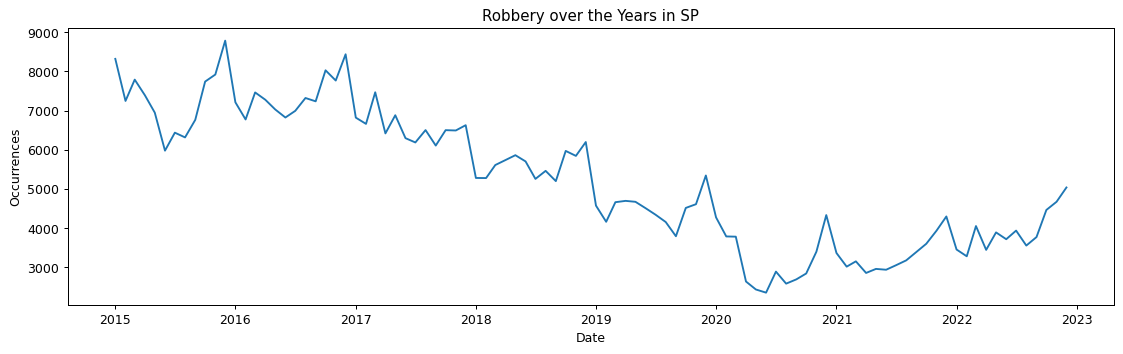

In [30]:
plot_dataset(grouped_df.index, grouped_df['Occurrences'], 'Date', 'Occurrences', 'Robbery over the Years in SP', figsize=(15,4))

### Plotting occurrences by month and year

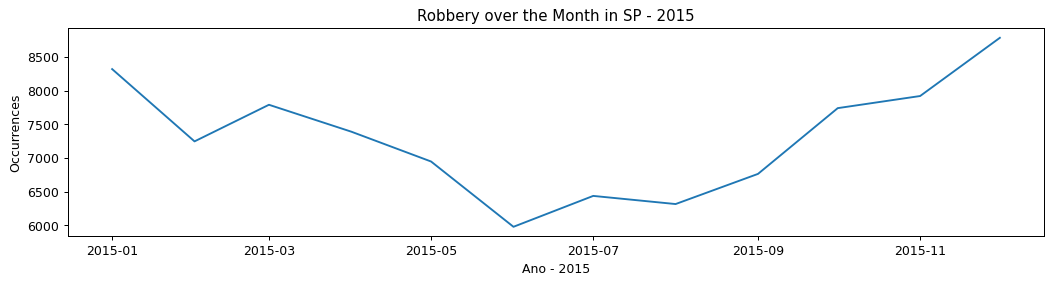

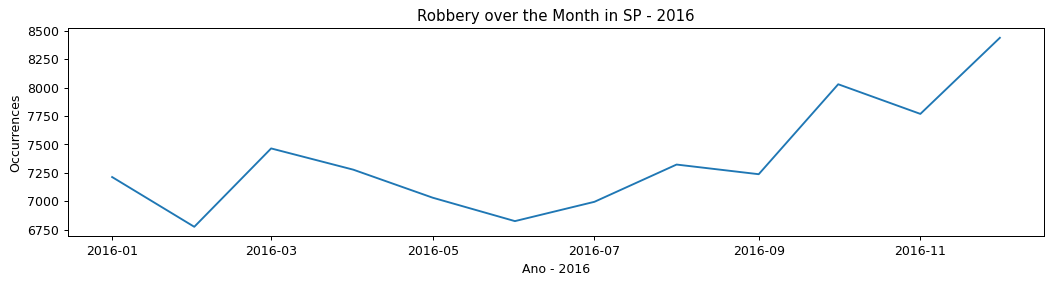

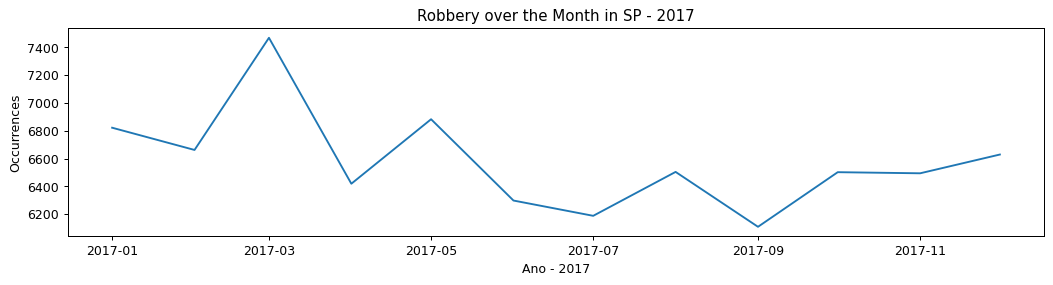

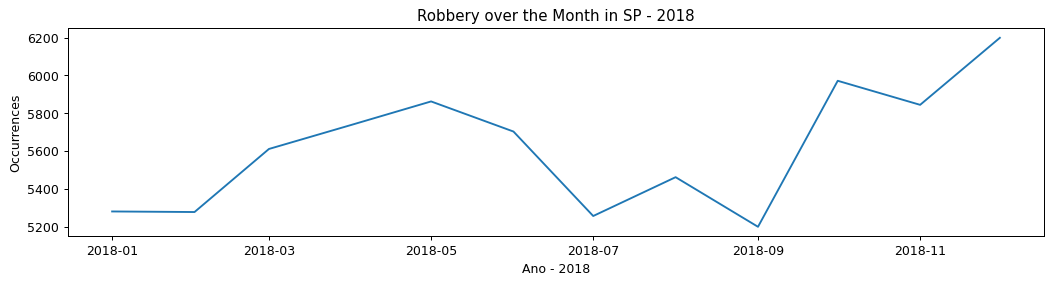

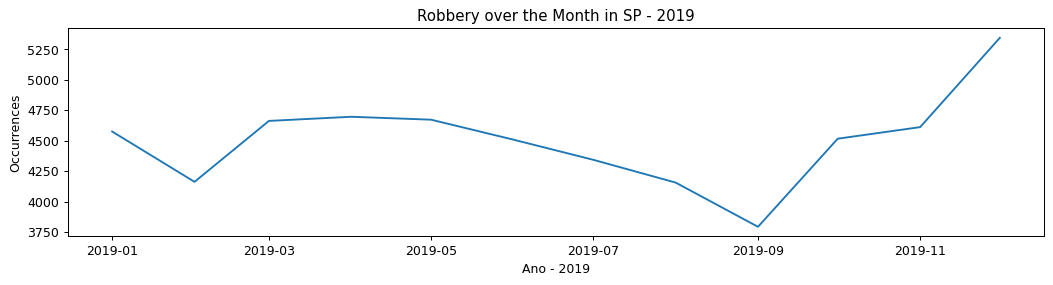

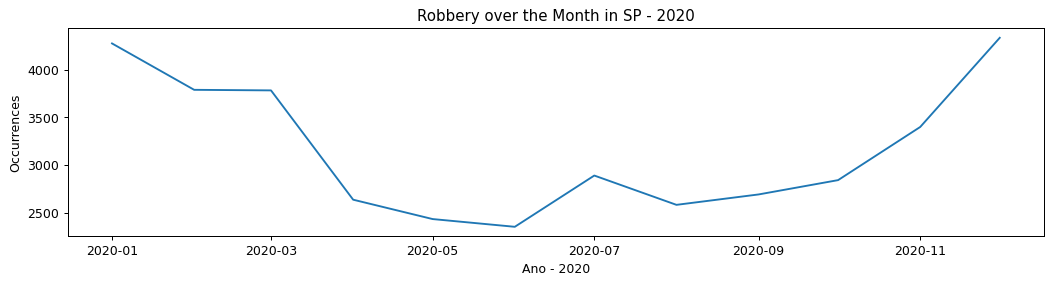

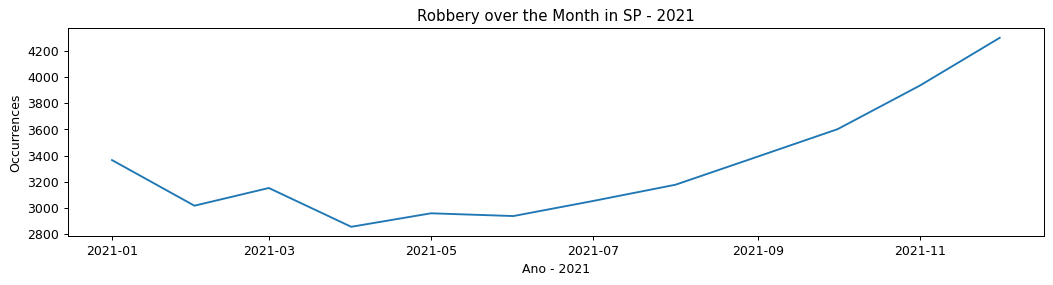

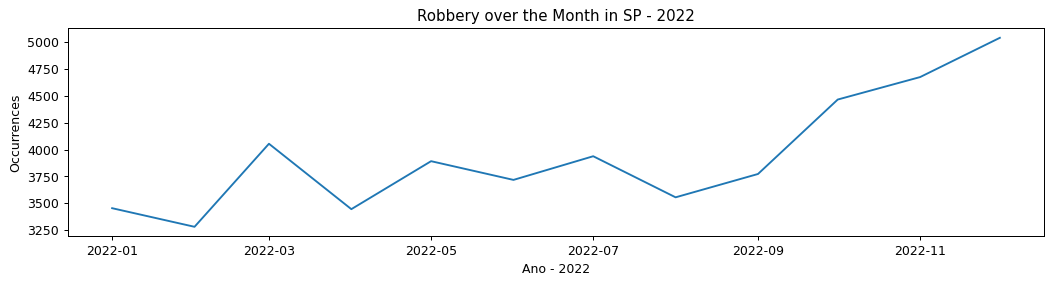

In [31]:
for year in grouped_df['Year'].unique():
  plot_dataset(grouped_df[grouped_df['Year'] == year].index,
              grouped_df[grouped_df['Year'] == year]['Occurrences'],
              f'Ano - {year}',
              'Occurrences',
              f'Robbery over the Month in SP - {year}', figsize=(14,3), dpi=3)

### Checking if Gaussian distribution makes sense

<Axes: >

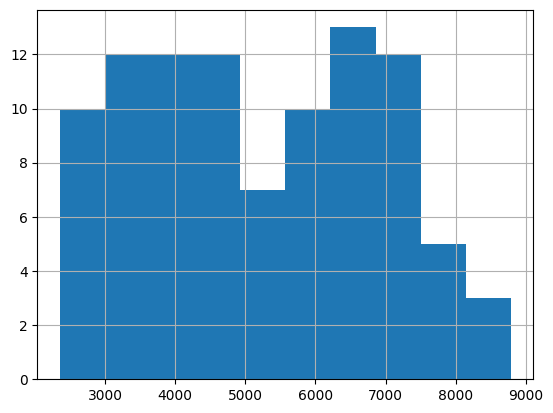

In [32]:
grouped_df['Occurrences'].hist()

## Decomposition

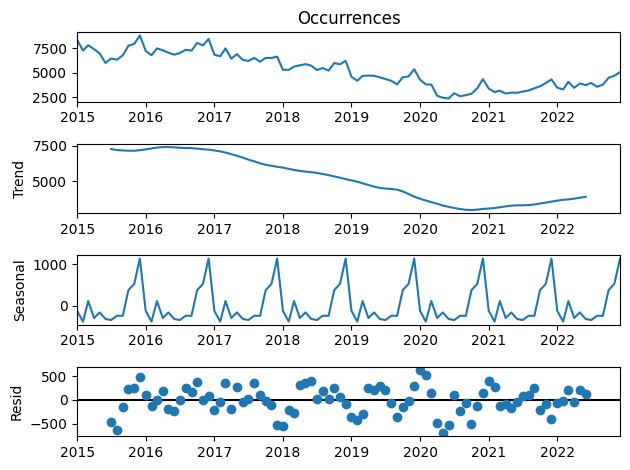

In [33]:
result = seasonal_decompose(grouped_df['Occurrences'], model='additive', period=12)
result.plot()
plt.show()

### Trend

<Axes: xlabel='Date'>

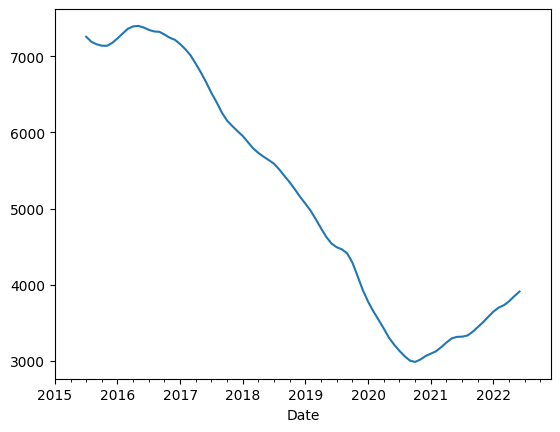

In [34]:
result.trend.plot()

#### De-trended

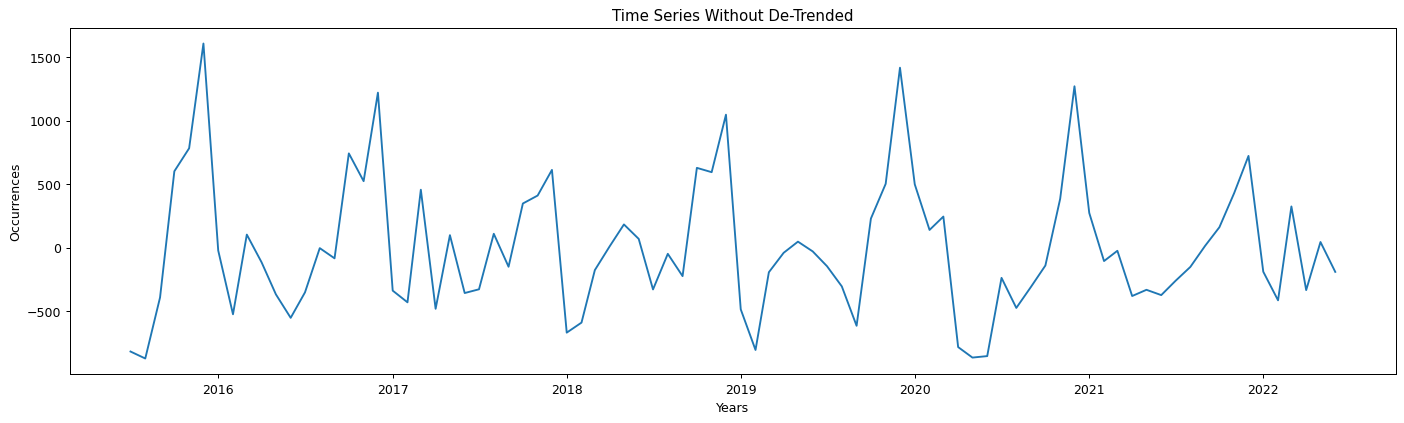

In [35]:
de_trended = grouped_df['Occurrences'] - result.trend
plot_dataset(grouped_df.index, de_trended, 'Years', 'Occurrences', 'Time Series Without De-Trended', figsize=(19,5))

### Sesanality

<Axes: xlabel='Date'>

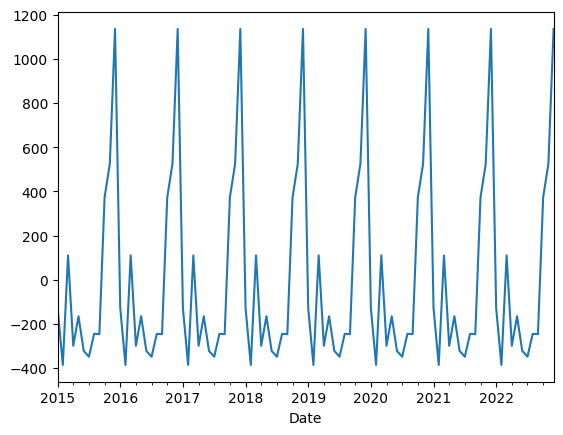

In [36]:
result.seasonal.plot()

#### De-seasonalized

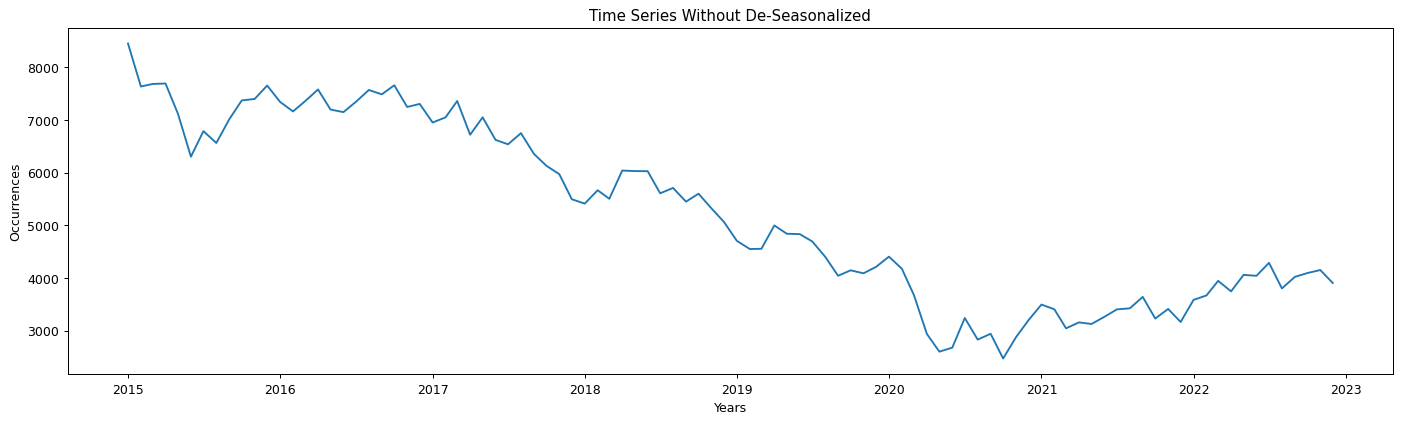

In [37]:
de_seasonalized = grouped_df['Occurrences'] - result.seasonal
plot_dataset(grouped_df.index, de_seasonalized, 'Years', 'Occurrences', 'Time Series Without De-Seasonalized', figsize=(19,5))

### Residual

<Axes: xlabel='Date'>

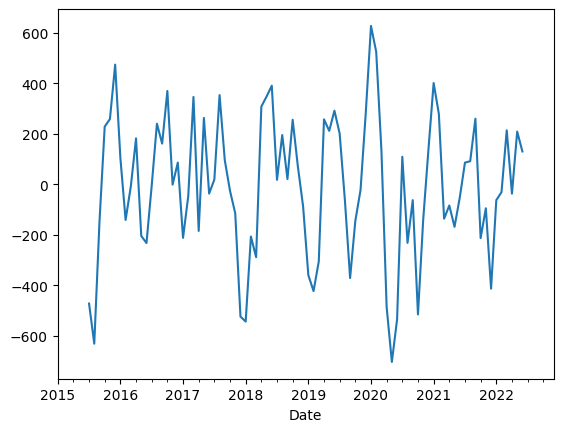

In [38]:
resudual = result.resid
resudual.plot()

## Stationarity

### Dickey–Fuller test

In [39]:
def check_stationarity(df):
  result = adfuller(df, autolag='AIC')

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
  print('\n\n')

In [40]:
check_stationarity(grouped_df['Occurrences'])

-- Dickey–Fuller test --
ADF Statistic: -1.382072
p-value: 0.590840
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





### Separating the time series into two groups and calculating the mean and variance of each.

In [41]:
def mean_variance(df):
  middle =  int(len(df) / 2)

  part_1, part_2 = df.head(middle), df.tail(middle)
  mean1, mean2 = part_1.mean(), part_2.mean()
  var1, var2 = part_1.var(), part_2.var()
  print('\n-- MEAN and VARIANCE --')
  print('Average of set 1: %f, Average of set 2: %f' % (mean1, mean2))
  print('variance of set 1: %f, Variance of set 2: %f\n' % (var1, var2))

In [42]:
mean_variance(grouped_df['Occurrences'])


-- MEAN and VARIANCE --
Average of set 1: 6717.291667, Average of set 2: 3731.562500
variance of set 1: 790520.721631, Variance of set 2: 555575.400266



### Autocorrelation

In [43]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")
  plt.show()

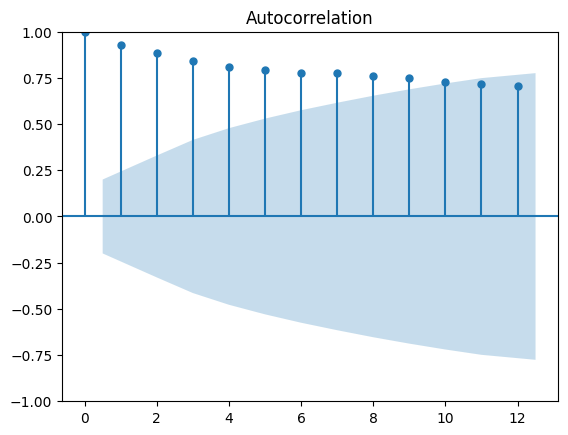

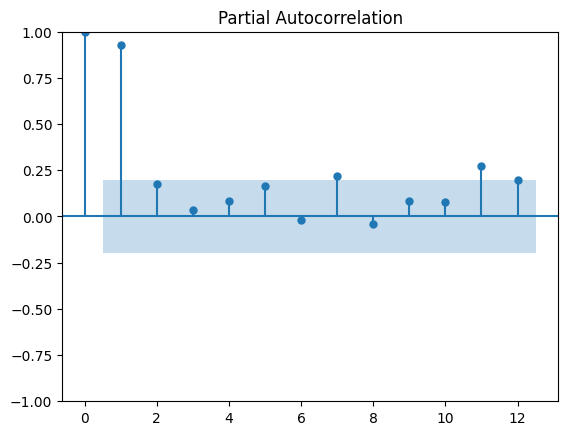

In [44]:
plot_autocorrelation(grouped_df['Occurrences'], lags=12)

### Converting series to stationary

#### Log transformation

In [45]:
dataset_log = np.log(grouped_df['Occurrences'])
dataset_log = dataset_log.diff().dropna()


-- MEAN and VARIANCE --
Average of set 1: -0.006266, Average of set 2: 0.002051
variance of set 1: 0.007923, Variance of set 2: 0.016231

-- Dickey–Fuller test --
ADF Statistic: -1.730042
p-value: 0.415704
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





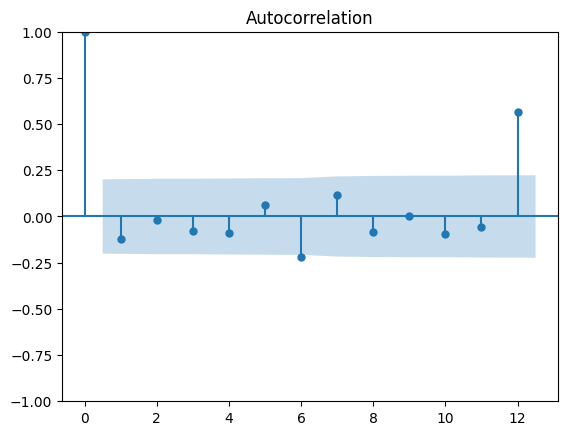

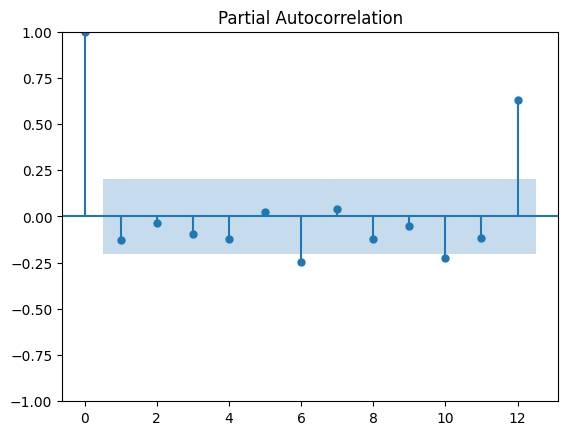

In [46]:
mean_variance(dataset_log)
check_stationarity(dataset_log)
plot_autocorrelation(dataset_log, lags=12)

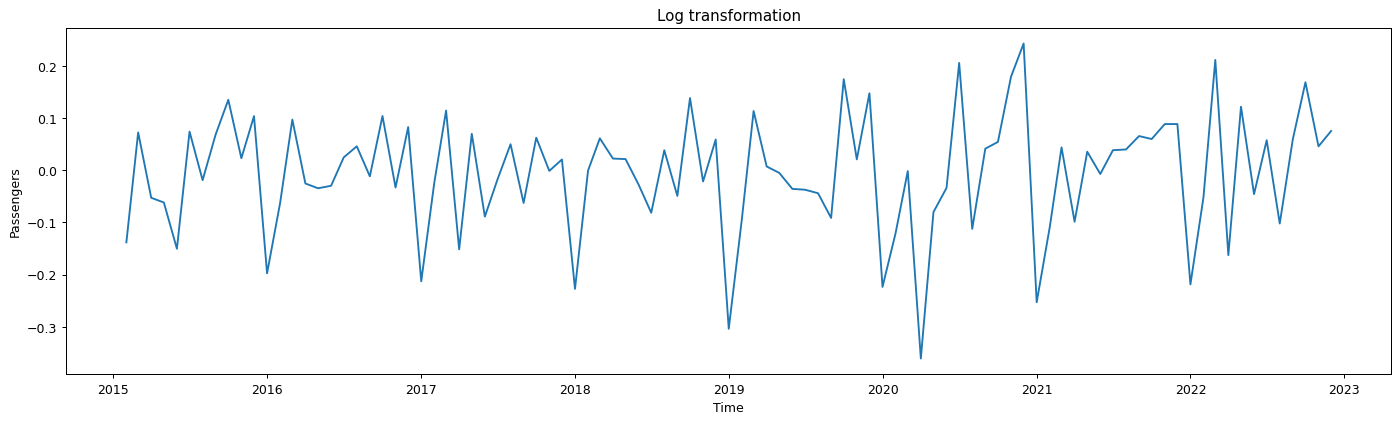

In [47]:
plot_dataset(dataset_log.index, dataset_log, 'Time', 'Passengers', "Log transformation", figsize=(19,5))

#### Difference

In [48]:
dataset_difference = grouped_df['Occurrences'] - grouped_df['Occurrences'].shift(1)
dataset_difference = dataset_difference.diff().dropna()
dataset_difference

Date
2015-03-01    1618.0
2015-04-01    -944.0
2015-05-01     -43.0
2015-06-01    -527.0
2015-07-01    1429.0
               ...  
2022-08-01    -602.0
2022-09-01     599.0
2022-10-01     475.0
2022-11-01    -483.0
2022-12-01     156.0
Name: Occurrences, Length: 94, dtype: float64


-- MEAN and VARIANCE --
Average of set 1: -11.680851, Average of set 2: 42.297872
variance of set 1: 1044700.482886, Variance of set 2: 527508.561517

-- Dickey–Fuller test --
ADF Statistic: -10.510637
p-value: 0.000000
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





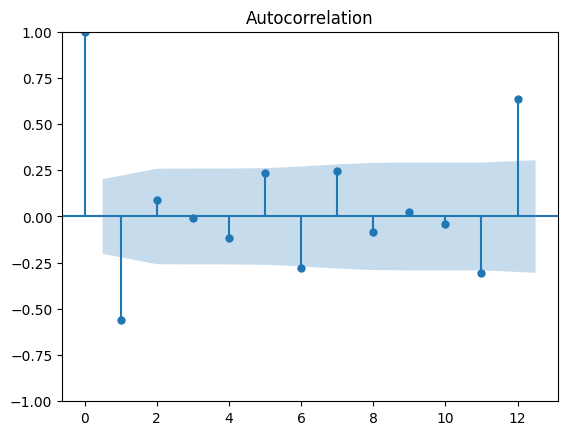

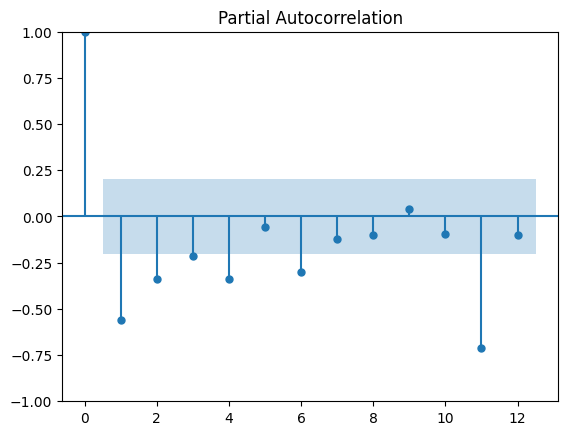

In [49]:
mean_variance(dataset_difference)
check_stationarity(dataset_difference)
plot_autocorrelation(dataset_difference, lags=12)

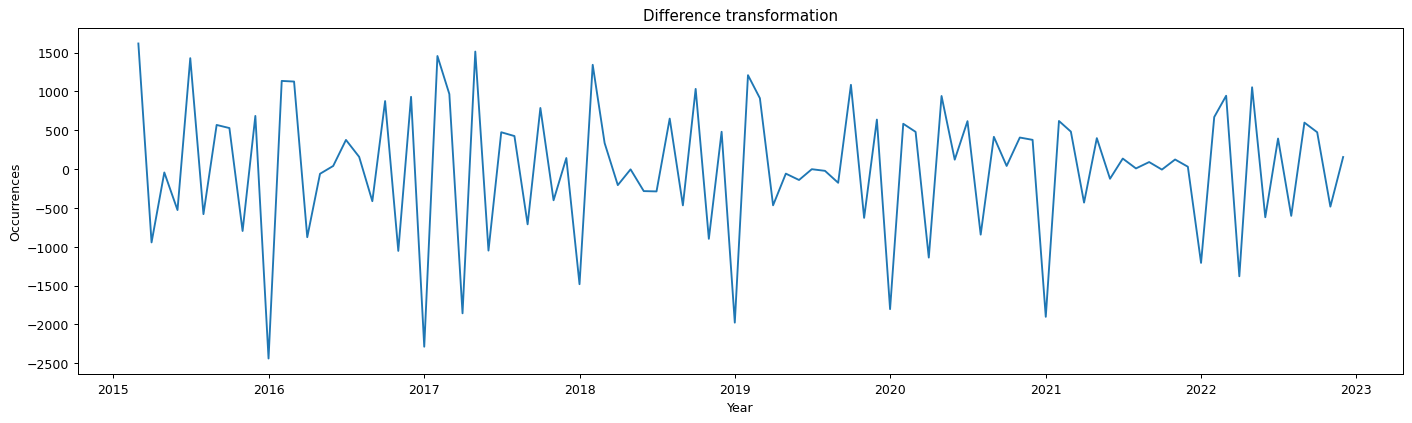

In [50]:
plot_dataset(dataset_difference.index, dataset_difference, 'Year', 'Occurrences', "Difference transformation", figsize=(19,5))

#### Seasonal Difference

In [51]:
dataset_seasonal_difference = grouped_df['Occurrences'] - grouped_df['Occurrences'].shift(12)
dataset_seasonal_difference = dataset_seasonal_difference.dropna()
dataset_seasonal_difference

Date
2016-01-01   -1109.0
2016-02-01    -473.0
2016-03-01    -327.0
2016-04-01    -114.0
2016-05-01      82.0
               ...  
2022-08-01     378.0
2022-09-01     380.0
2022-10-01     863.0
2022-11-01     739.0
2022-12-01     740.0
Name: Occurrences, Length: 84, dtype: float64


-- MEAN and VARIANCE --
Average of set 1: -629.380952, Average of set 2: -331.595238
variance of set 1: 446134.924506, Variance of set 2: 977870.588269

-- Dickey–Fuller test --
ADF Statistic: -2.010186
p-value: 0.282125
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





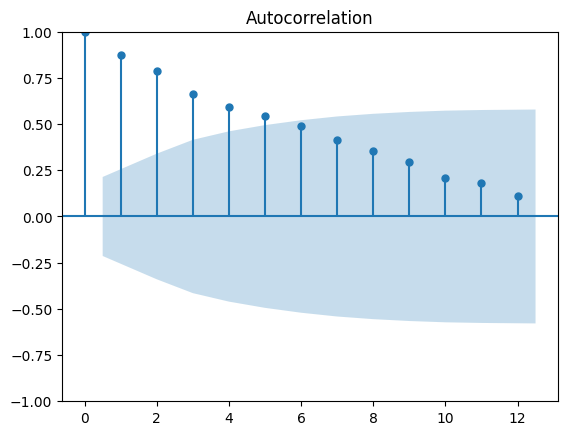

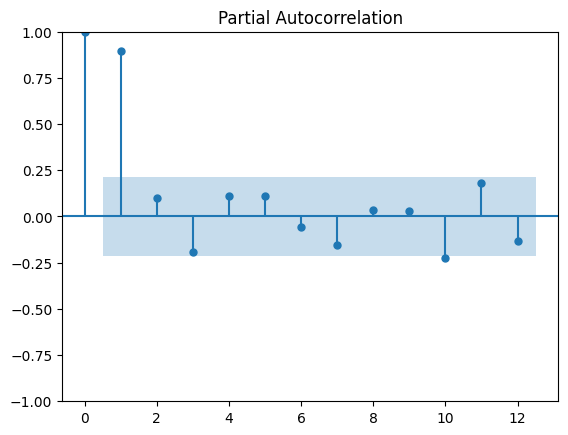

In [52]:
mean_variance(dataset_seasonal_difference)
check_stationarity(dataset_seasonal_difference)
plot_autocorrelation(dataset_seasonal_difference, lags=12)

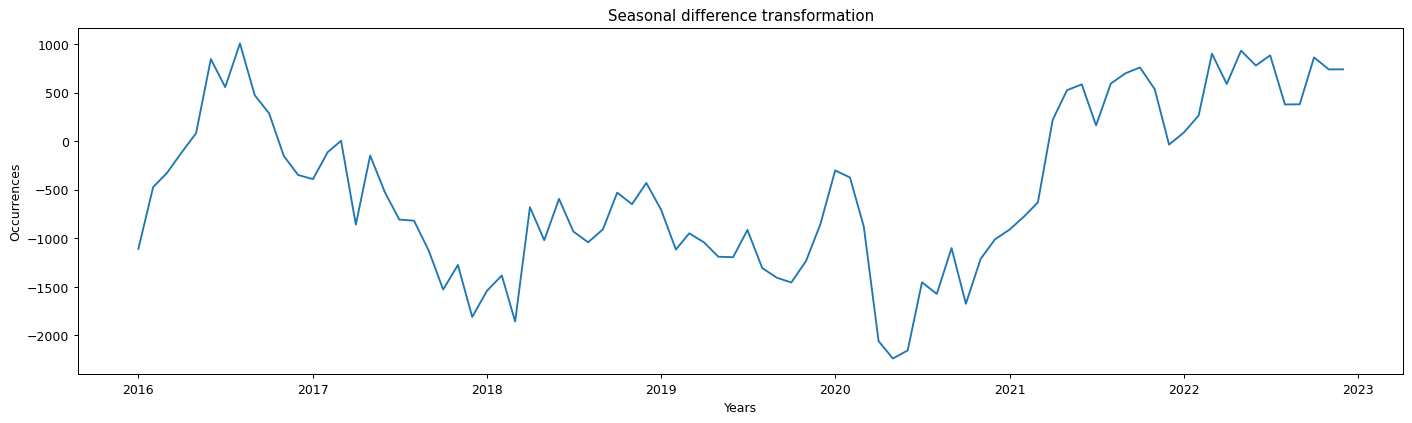

In [53]:
plot_dataset(dataset_seasonal_difference.index, dataset_seasonal_difference, 'Years', 'Occurrences', "Seasonal difference transformation", figsize=(19,5))

#### Taking the square root of the data

In [54]:
dataset_sqrt = np.sqrt(grouped_df['Occurrences'])
dataset_sqrt = dataset_sqrt.diff().dropna()
dataset_sqrt

Date
2015-02-01   -6.089810
2015-03-01    3.137119
2015-04-01   -2.295565
2015-05-01   -2.616079
2015-06-01   -6.036668
                ...   
2022-08-01   -3.121280
2022-09-01    1.792545
2022-10-01    5.395905
2022-11-01    1.546003
2022-12-01    2.619256
Name: Occurrences, Length: 95, dtype: float64


-- MEAN and VARIANCE --
Average of set 1: -0.265772, Average of set 2: 0.071059
variance of set 1: 13.736004, Variance of set 2: 14.944599

-- Dickey–Fuller test --
ADF Statistic: -1.637436
p-value: 0.463601
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





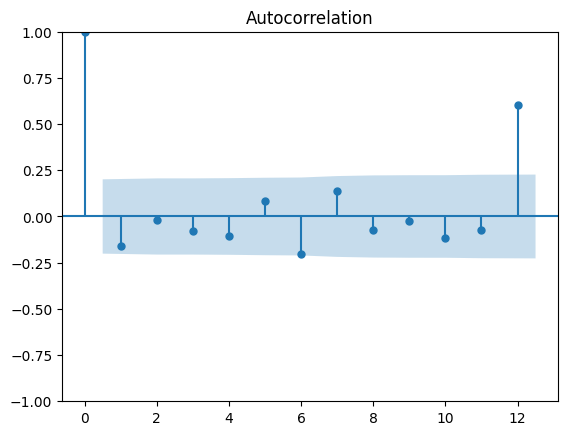

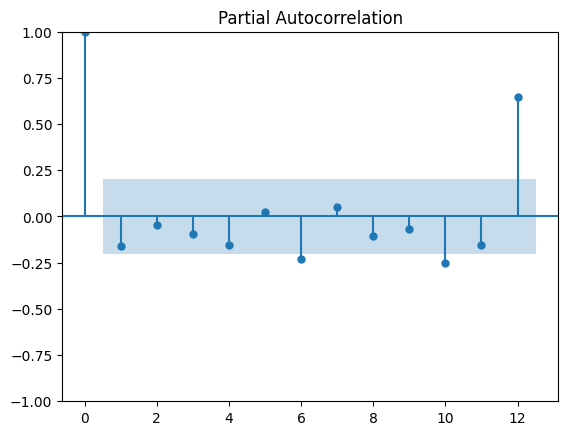

In [55]:
mean_variance(dataset_sqrt)
check_stationarity(dataset_sqrt)
plot_autocorrelation(dataset_sqrt, lags=12)

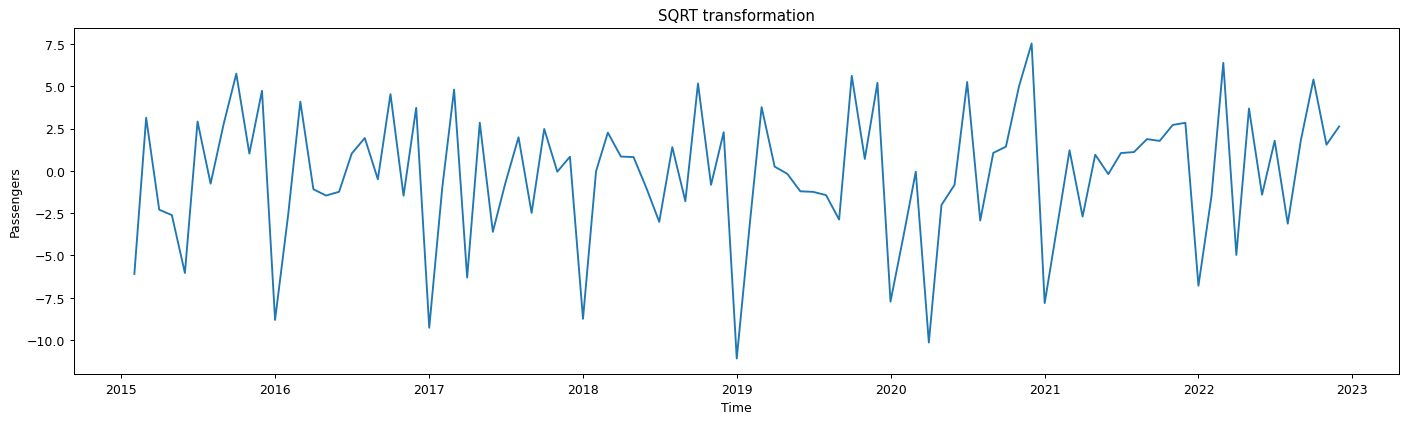

In [56]:
plot_dataset(dataset_sqrt.index, dataset_sqrt, 'Time', 'Passengers', "SQRT transformation", figsize=(19,5))

#### Applying transformation

In [57]:
transformed_df = grouped_df.copy()
transformed_df['Occurrences'] = dataset_difference
transformed_df = transformed_df.dropna()
transformed_df.head(5)

,Year,Month,Occurrences
Date,,,
2015-03-01,2015,3,1618.0
2015-04-01,2015,4,-944.0
2015-05-01,2015,5,-43.0
2015-06-01,2015,6,-527.0
2015-07-01,2015,7,1429.0


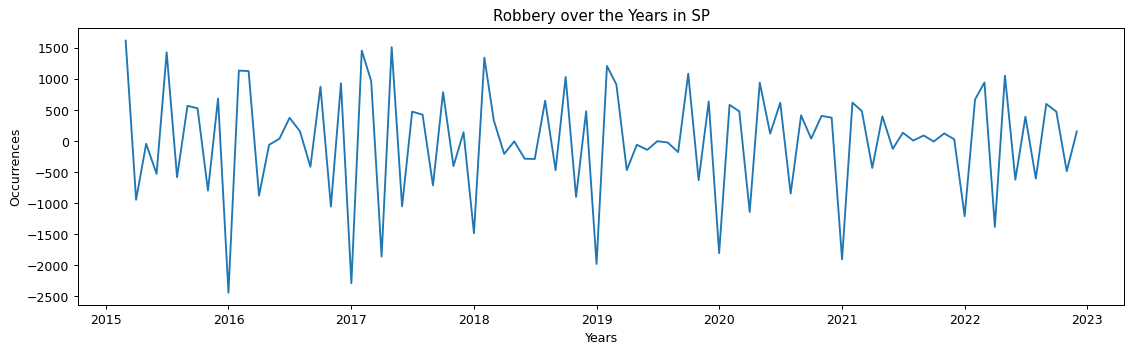

In [58]:
plot_dataset(transformed_df.index, transformed_df['Occurrences'], 'Years', 'Occurrences', 'Robbery over the Years in SP', figsize=(15,4))

## Encoding Data derived Features

In [59]:
def encode(data, col, max_val):
    """
    Encodes cyclical data, such as days and months.
    """

    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)

    return data

In [60]:
encoded_df = transformed_df.copy()

encoded_df['Day_of_Year'] = encoded_df.index.dayofyear

encoded_df = encode(encoded_df, 'Day_of_Year', 366)
encoded_df = encode(encoded_df, 'Month', 12)

encoded_df = encoded_df.drop(columns={'Month', 'Day_of_Year', 'Year'})
encoded_df

,Occurrences,Day_of_Year_sin,Day_of_Year_cos,Month_sin,Month_cos
Date,,,,,
2015-03-01,1618.0,0.857315,0.514793,1.000000e+00,6.123234e-17
2015-04-01,-944.0,0.999963,0.008583,8.660254e-01,-5.000000e-01
2015-05-01,-43.0,0.874481,-0.485060,5.000000e-01,-8.660254e-01
2015-06-01,-527.0,0.507415,-0.861702,1.224647e-16,-1.000000e+00
2015-07-01,1429.0,0.017166,-0.999853,-5.000000e-01,-8.660254e-01
...,...,...,...,...,...
2022-08-01,-602.0,-0.492548,-0.870285,-8.660254e-01,-5.000000e-01
2022-09-01,599.0,-0.866025,-0.500000,-1.000000e+00,-1.836970e-16
2022-10-01,475.0,-0.999963,-0.008583,-8.660254e-01,5.000000e-01


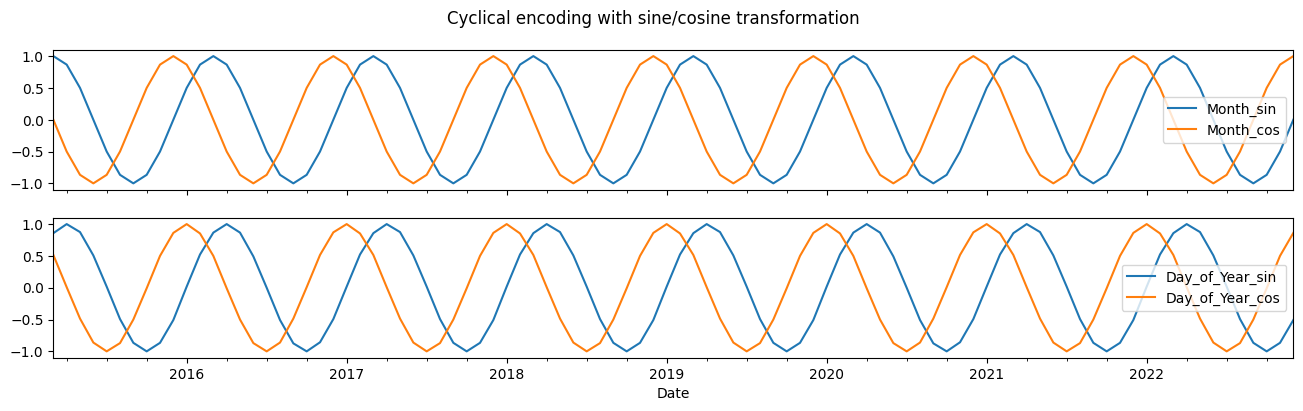

In [61]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,4))
encoded_df[["Month_sin", "Month_cos"]].plot(ax=ax[0])
encoded_df[["Day_of_Year_sin", "Day_of_Year_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

# Training the model

## Splitting data

In [62]:
TEST_CUTOFF = '2020-01-01'

In [63]:
# # Create pandas Series
# Occurrences     = pd.Series(encoded_df['Occurrences'])
# Day_of_Year_sin = pd.Series(encoded_df['Day_of_Year_sin'])
# Day_of_Year_cos = pd.Series(encoded_df['Day_of_Year_cos'])
# Month_sin       = pd.Series(encoded_df['Month_sin'])
# Month_cos       = pd.Series(encoded_df['Month_cos'])

# # # It also supports to combine multiple series.
# encoded_series = pd.concat([Occurrences, Day_of_Year_sin, Day_of_Year_cos, Month_sin, Month_cos], axis=1)

# df_train = encoded_series[encoded_series.index < TEST_CUTOFF]
# df_test = encoded_series[encoded_series.index >= TEST_CUTOFF]

In [99]:
df_train = encoded_df[encoded_df.index < TEST_CUTOFF]
df_test = encoded_df[encoded_df.index >= TEST_CUTOFF]

In [100]:
df_test_y = df_test[['Occurrences']]
df_test.drop(columns='Occurrences', inplace=True)

<ipython-input-100-21b5d158e478>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns='Occurrences', inplace=True)


## XGBoost

### Create forecaster

In [65]:
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=123),
    lags = 12
)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables 

### Grid search of Hyperparameter tuning (tuning)

In [66]:
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_deep': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [12, 24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df_test, # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(df_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 80.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

TypeError: ignored

## Prophet

In [104]:
df_train['ds'] = df_train.index
df_train['y'] = df_train['Occurrences']

df_train.drop(columns='Occurrences',  inplace=True)

<ipython-input-104-7a50ba04056f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ds'] = df_train.index
<ipython-input-104-7a50ba04056f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = df_train['Occurrences']
<ipython-input-104-7a50ba04056f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trai

In [83]:
prophet = Prophet(interval_width=0.9)

prophet.add_regressor('Day_of_Year_sin', standardize=False)
prophet.add_regressor('Day_of_Year_cos', standardize=False)
prophet.add_regressor('Month_sin', standardize=False)
prophet.add_regressor('Month_cos', standardize=False)
prophet.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpufl7v84g/5s7b7wyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpufl7v84g/hk6yqtlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63295', 'data', 'file=/tmp/tmpufl7v84g/5s7b7wyo.json', 'init=/tmp/tmpufl7v84g/hk6yqtlp.json', 'output', 'file=/tmp/tmpufl7v84g/prophet_modelvu8yxz0j/prophet_model-20230628202959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [84]:
prophet.params

OrderedDict([('lp__', array([[77.8503]])),
             ('k', array([[-0.0334772]])),
             ('m', array([[0.00013355]])),
             ('delta',
              array([[-7.63958e-12, -4.22671e-10, -6.39703e-10, -4.80421e-10,
                      -5.16947e-10, -7.20631e-10,  5.51602e-10,  5.44067e-10,
                      -1.32768e-10,  8.07794e-10,  5.96176e-10,  2.73643e-10,
                      -3.88910e-10, -1.28493e-10,  2.15983e-10,  3.60824e-10,
                      -2.15658e-10,  6.17278e-11, -4.53445e-10,  2.36867e-10,
                       2.61926e-10, -3.84521e-10,  4.28237e-10, -6.24028e-10,
                      -2.31249e-10]])),
             ('sigma_obs', array([[0.157986]])),
             ('beta',
              array([[-0.297327 , -0.456369 ,  0.703251 ,  0.0557615,  0.369885 ,
                      -0.291583 , -0.276436 , -0.969419 ,  0.134002 ,  0.647902 ,
                      -0.367738 , -0.0968898,  0.561772 , -0.868073 , -0.40613  ,
                       

In [108]:
df_test['ds'] = df_test.index

result = prophet.predict(df_test)
result[['ds', 'yhat']].head()

<ipython-input-108-3e11b2043592>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ds'] = df_test.index


,ds,yhat
0,2020-01-01,-2227.913789
1,2020-02-01,1086.551545
2,2020-03-01,871.937688
3,2020-04-01,-1279.425940
4,2020-05-01,528.622708


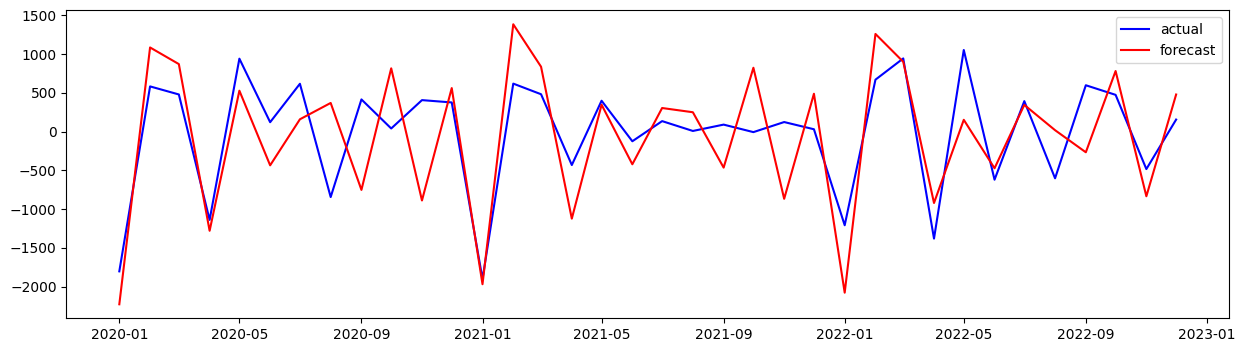

In [103]:
plt.figure(figsize=(15,4))
plt.plot(df_test.index, df_test_y['Occurrences'], color='blue', label='actual')
plt.plot(result.ds, result['yhat'], color='red', label='forecast')
plt.legend()

In [116]:
print(f"RMSE: {mean_squared_error(df_test_y['Occurrences'], result['yhat'])}")

RMSE: 378450.2755416925


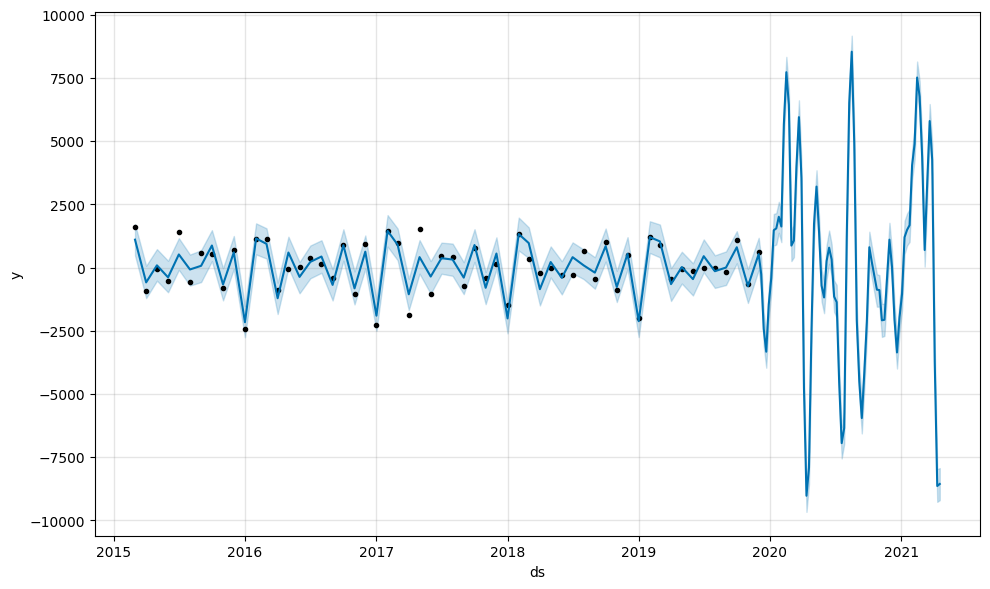

In [139]:
# future   = prophet.make_future_dataframe(periods=72, freq='W', include_history=True)

# future['Month']       = future['ds'].dt.month
# future['Day_of_Year'] = future['ds'].dt.dayofyear

# future = encode(future, 'Day_of_Year', 366)
# future = encode(future, 'Month', 12)

# future = future.drop(columns={'Month', 'Day_of_Year'})

# forecast = prophet.predict(future)

# prophet.plot(forecast)
# plt.show()